In [32]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from matplotlib.dates import date2num, num2date
from matplotlib.colors import ListedColormap
from matplotlib import dates as mdates
from matplotlib.patches import Patch
from matplotlib import pyplot as plt
from matplotlib import ticker

import scipy

import sys

sys.path.insert(0, '..')

### ---- ###
from functions.adjust_cases_functions import prepare_cases, confirmed_to_onset
from global_config import config


dict_map = {'10-10': (0,19), '10-19': (10, 19), '20-39': (20,39), '40-49': (40,49),
            '50-59': (50,59), '60-69': (60,69), '70-90+': (70,200) }

NGroups  = len(dict_map)

def age_group(val, dict_map):
    for ag in dict_map:
        if dict_map[ag][0] <= val <= dict_map[ag][1]:
            return ag
    return 'NaN'

data_dir      = config.get_property('data_dir_covid')
data_dir_mnps = config.get_property('data_dir_col')
results_dir   = config.get_property('results_dir')
colev_dir   = config.get_property('colev_dir')

location_folder = 'colombia'
agglomeration_method = 'geometry'
type_run = 'all'


In [2]:


# Agglomerated folder location
agglomerated_folder = os.path.join(data_dir, 'data_stages', location_folder, 'agglomerated', agglomeration_method )

raw_folder          = os.path.join(data_dir, 'data_stages', location_folder, 'raw' , 'cases')

poly_agg_path  = os.path.join(data_dir_mnps, 'administrative_division_col_2018.csv' )
poly_agg_df    = pd.read_csv(poly_agg_path, sep =',').set_index('poly_id')


cases_df_all = pd.read_csv(os.path.join(agglomerated_folder, 'cases.csv'), parse_dates =['date_time']).set_index('poly_id')
cases_df = cases_df_all.copy()

#poly_id2location = cases_df.copy().reset_index().groupby(['poly_id', 'location']).sum().reset_index()[['poly_id', 'location']].set_index('poly_id')

cases_raw_df = pd.read_csv(os.path.join(raw_folder, 'cases_raw.csv'), parse_dates =['Fecha de inicio de síntomas', 'Fecha de diagnóstico', 'Fecha de muerte'], dayfirst=True) #.set_index('poly_id')
cases_raw_df['age_group'] = cases_raw_df['Edad'].apply(lambda x: age_group( x, dict_map) )
cases_raw_df = cases_raw_df[['Código DIVIPOLA municipio', 'Nombre municipio', 'Nombre departamento',  'age_group', 'Sexo' ,'Fecha de inicio de síntomas', 'Fecha de diagnóstico', 'Fecha de muerte']]
cases_raw_df = cases_raw_df.rename(columns={'Código DIVIPOLA municipio': 'poly_id'})

#poly_id2location = cases_raw_df.copy().reset_index().groupby(['poly_id','Nombre municipio', 'Nombre departamento']).sum().reset_index().set_index('poly_id')
#poly_id2location['location'] = poly_id2location.apply(lambda x: x['Nombre municipio'].lower()+'-'+x['Nombre departamento'].lower(), axis=1).reset_index()

list_df_ages = []
for age_g in dict_map.keys():
    cases_agei = cases_raw_df[cases_raw_df.age_group==age_g].copy()
    cases_agei['num_cases']    = 1
    cases_agei['num_diseased'] = 1
    cases_agei_num_cases  = cases_agei.copy().groupby(['Fecha de diagnóstico','poly_id']).sum().reset_index().rename(columns={'Fecha de diagnóstico': 'date_time'})[['date_time','poly_id','num_cases']]
    cases_agei_num_deaths = cases_agei.copy()[['Fecha de muerte','poly_id','num_diseased']].dropna().groupby(['Fecha de muerte','poly_id']).sum().reset_index().rename(columns={'Fecha de muerte': 'date_time'})
    new_df = pd.merge(cases_agei_num_cases, cases_agei_num_deaths,  how='outer').fillna(0)
    new_df = new_df.groupby(['date_time','poly_id']).sum().reset_index().set_index('poly_id')
    new_df['age_group'] = age_g
    list_df_ages.append(new_df)

cases_df_agg = cases_df.reset_index()[['poly_id','date_time', 'num_cases', 'num_diseased']]
cases_df_agg['age_group'] = 'agg'
list_df_ages.append(cases_df_agg.set_index('poly_id'))
df_cases_ages = pd.concat(list_df_ages)

poly_df  = pd.read_csv(os.path.join(agglomerated_folder, 'polygons.csv')).set_index('poly_id')

## add time delta
df_polygons = pd.read_csv( os.path.join( agglomerated_folder ,  "polygons.csv") )

# Time delay between FIS and diagnosis date
poly_df   = pd.read_csv( os.path.join( agglomerated_folder ,  "polygons.csv") ).set_index('poly_id')
pop_df = poly_df.copy()[['attr_area', 'geometry', 'attr_population']]

poly_df = poly_df.dropna(subset=['attr_time-delay_dist_mix', 'attr_time_death-delay_dist_mix'], axis='rows')

poly_df["attr_time-delay_dist_mix"] = poly_df["attr_time-delay_dist_mix"].fillna("")
poly_df = poly_df.dropna(subset=['attr_time-delay_dist_mix'], axis=0)
poly_df["attr_time_diag_delay"] = poly_df.apply(lambda x: np.fromstring(x["attr_time-delay_dist_mix"], sep="|"), axis=1)
poly_df = poly_df[poly_df['attr_time_diag_delay'].map(lambda x: len(x)) > 0]
poly_df = poly_df[poly_df['attr_time_diag_delay'].map(lambda x: ~np.isnan(list(x)[0] ))]


poly_df["attr_time_death-delay_dist_mix"] = poly_df["attr_time_death-delay_dist_mix"].fillna("")
poly_df["attr_time_death_delay"]          = poly_df.apply(lambda x: np.fromstring(x["attr_time_death-delay_dist_mix"], sep="|"), axis=1)
poly_df = poly_df.dropna(subset=['attr_time_death-delay_dist_mix'], axis=0)
poly_df["attr_time_death_delay"] = poly_df.apply(lambda x: np.fromstring(x["attr_time_death-delay_dist_mix"], sep="|"), axis=1)
poly_df = poly_df[poly_df['attr_time_death_delay'].map(lambda x: len(x)) > 0]
poly_df = poly_df[poly_df['attr_time_death_delay'].map(lambda x: ~np.isnan(list(x)[0] ))]

agg_p_delay_diag  = pd.DataFrame(list(poly_df['attr_time_diag_delay'])).mean().to_numpy()
agg_p_delay_diag[0] = 0

agg_p_delay_death = pd.DataFrame(list(poly_df['attr_time_death_delay'])).mean().to_numpy()
agg_p_delay_death[0] = 0

def crosscorr(series1, series2, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return series2.corr(series1.shift(lag))


def compute_correlation(cases, deaths, lags = list(range(41)), start_day='01-04-2020', final_day=None):

    if not start_day:
        start_day = min(cases.index.values[0], deaths.index.values[0])
    if not final_day:
        final_day = min(cases.index.values[-1], deaths.index.values[-1])

    min_date = pd.to_datetime(start_day, dayfirst=True)
    max_date = pd.to_datetime(final_day, dayfirst=True)

    cases = cases.loc[start_day:max_date]
    deaths = deaths.loc[start_day:max_date]

    corr_df = pd.DataFrame(columns = ['lag', 'value'])
    corr_df['lag'] = lags
    corr_df = corr_df.set_index('lag')

    for idx, lag in enumerate(lags):
        corr_df.loc[lag]['value'] = crosscorr(cases, deaths, lag=lag)

    return corr_df


def cfr(cases, deaths, lag, start_day='01-04-2020', final_day=None):

    if not start_day:
        start_day = min(cases.index.values[0], deaths.index.values[0])
    if not final_day:
        final_day = min(cases.index.values[-1], deaths.index.values[-1])

    #start_day = '01-04-2020'
    #final_day = '31-10-2020'

    min_date = pd.to_datetime(start_day, dayfirst=True)
    max_date = pd.to_datetime(final_day, dayfirst=True)

    min_init = min(cases.index.values[0], deaths.index.values[0])
    min_date = min(min_date, min_init)

    max_init = min(cases.index.values[-1], deaths.index.values[-1])
    max_date = min(max_date, max_init)


    cases = cases.loc[min_date:max_date]
    deaths = deaths.loc[min_date:max_date]

    cfr = pd.DataFrame(columns = ['date_time', 'value'])

    #cfr['date_time'] = pd.date_range(start=min_date, end=max_date, freq='D')
    #cfr['value']     = deaths.shift(lag).values / cases.values

    return deaths.shift(lag).values / cases.values

cases_df['state']    = cases_df.apply(lambda x: x['location'].split('-')[-1], axis=1)
state2id = {}
for state_id in cases_df['state'].unique():
    poly_id = str(cases_df.reset_index().set_index("state").loc[state_id]['poly_id'].iloc[0])
    if len(poly_id)==4: #==state_id")['poly_id'].iloc[0])==4:
        state2id[state_id] = '0'+poly_id[:1]
    else:
        state2id[state_id] = poly_id[:2]

def get_location_state(poly_id, cases_df_all):
    try:
        location = cases_df_all.loc[poly_id]['location'].iloc[0]
    except:
        return 'None'

    return (location.split('-')[0], location.split('-')[1])

from tqdm import tqdm
poly_info = {}

df_all = []
for idx, poly_id in tqdm(enumerate(cases_df.reset_index()['poly_id'].unique())):

    # If polygon not in polygons use aggregated p_delay
    if poly_id in poly_df.index.values:
        p_delay_diag = poly_df.loc[poly_id]["attr_time_diag_delay"]
    else:
        p_delay_diag = agg_p_delay_diag

    if poly_id in poly_df.index.values:
        p_delay_death = poly_df.loc[poly_id]["attr_time_death_delay"]
    else:
        p_delay_death = agg_p_delay_death

    try:
        list_cases_df = []
        for age_group in df_cases_ages.age_group.unique():
            cases_df = df_cases_ages[df_cases_ages.age_group==age_group]
            cases  = cases_df.loc[poly_id][['date_time','num_cases']].set_index('date_time').resample('D').sum().fillna(0)[['num_cases']]
            cases  = prepare_cases(cases, col='num_cases', cutoff=0)
            cases['age_group'] = age_group
            list_cases_df.append(cases)
        cases = pd.concat(list_cases_df)
        cases["poly_id"] = [poly_id]*len(cases)
        cases["poly_name"] = get_location_state(poly_id, cases_df_all)[0]
        cases["poly_state"] = get_location_state(poly_id, cases_df_all)[1]

    except:
        continue

    list_deaths_df = []
    for age_group in df_cases_ages.age_group.unique():
        deaths_df = df_cases_ages[df_cases_ages.age_group==age_group]
        deaths  = deaths_df.loc[poly_id][['date_time','num_diseased']].set_index('date_time').resample('D').sum().fillna(0)[['num_diseased']]
        deaths  = prepare_cases(deaths, col='num_diseased', cutoff=0)
        deaths['age_group'] = age_group
        list_deaths_df.append(deaths)
    deaths = pd.concat(list_deaths_df)
    deaths["poly_id"] = [poly_id]*len(deaths)
    deaths["poly_name"] = get_location_state(poly_id, cases_df_all)[0]
    deaths["poly_state"] = get_location_state(poly_id, cases_df_all)[1]
    deaths = deaths.reset_index().set_index(['date_time', 'poly_id', 'poly_name', 'poly_state', 'age_group'])
    cases  = cases.reset_index().set_index(['date_time', 'poly_id', 'poly_name', 'poly_state', 'age_group'])



    
    df_merged = pd.merge(cases, deaths, left_index=True, right_index=True)
    df_all.append(df_merged)
df_cases_all = pd.concat(df_all)



/Users/chaosdonkey06/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (14,22) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
1102it [06:49,  2.69it/s]


In [3]:

df_cases_all


,,,,,num_cases,smoothed_num_cases,num_diseased,smoothed_num_diseased
date_time,poly_id,poly_name,poly_state,age_group,,,,
2020-07-30,5467,Montebello,Antioquia,10-10,1.0,0.0,0.0,0.0
2020-07-31,5467,Montebello,Antioquia,10-10,0.0,0.0,0.0,0.0
2020-08-01,5467,Montebello,Antioquia,10-10,0.0,0.0,0.0,0.0
2020-08-02,5467,Montebello,Antioquia,10-10,0.0,0.0,0.0,0.0
2020-08-03,5467,Montebello,Antioquia,10-10,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2021-01-11,99773,Cumaribo,Vichada,agg,0.0,0.0,0.0,0.0
2021-01-12,99773,Cumaribo,Vichada,agg,0.0,0.0,0.0,0.0
2021-01-13,99773,Cumaribo,Vichada,agg,0.0,0.0,0.0,0.0


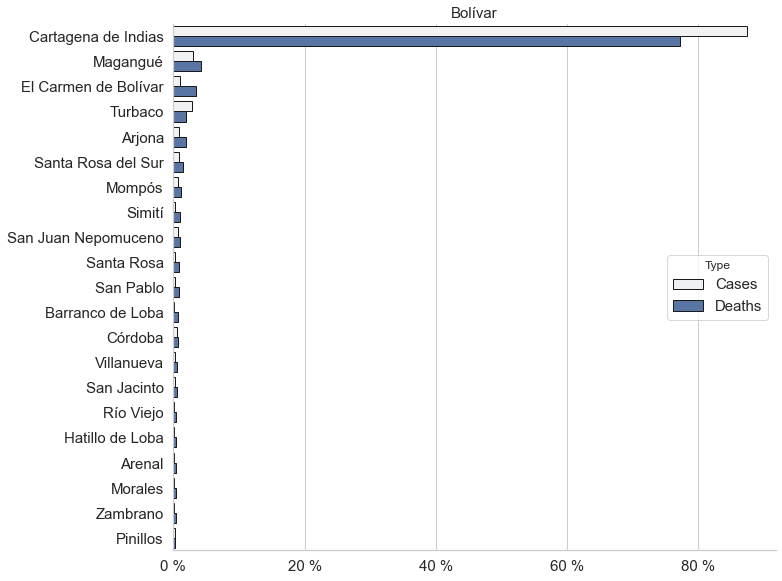

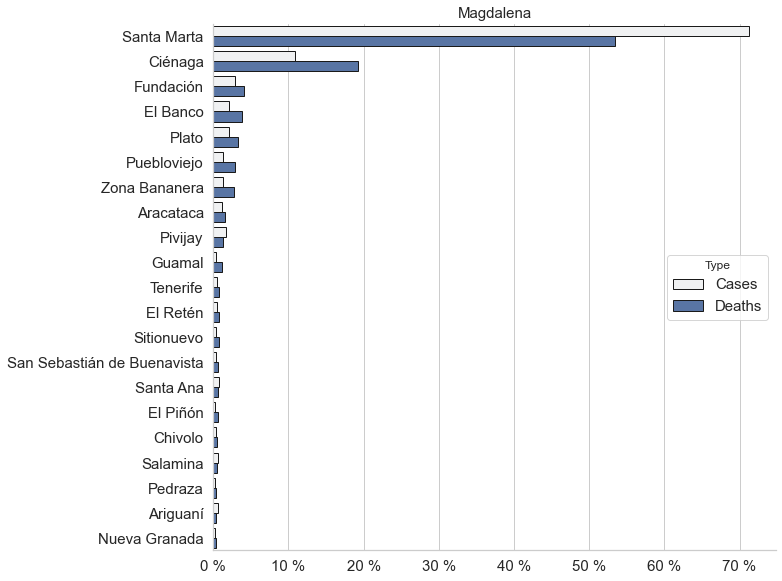

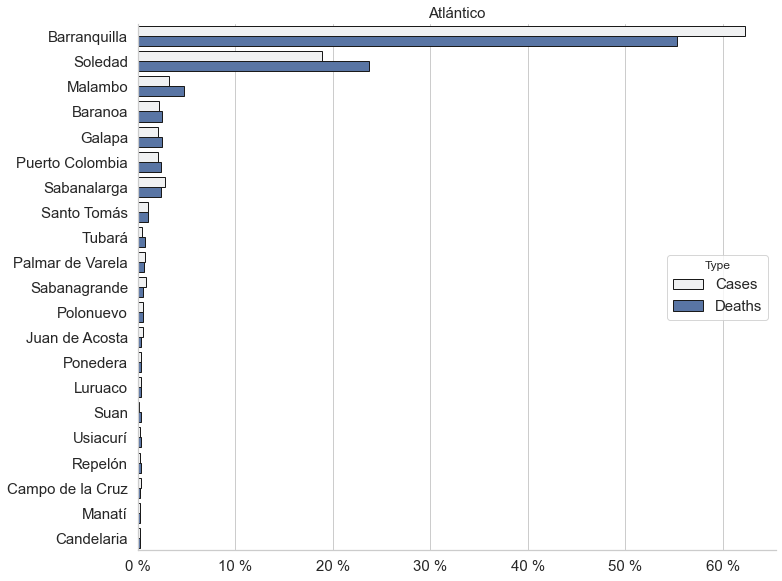

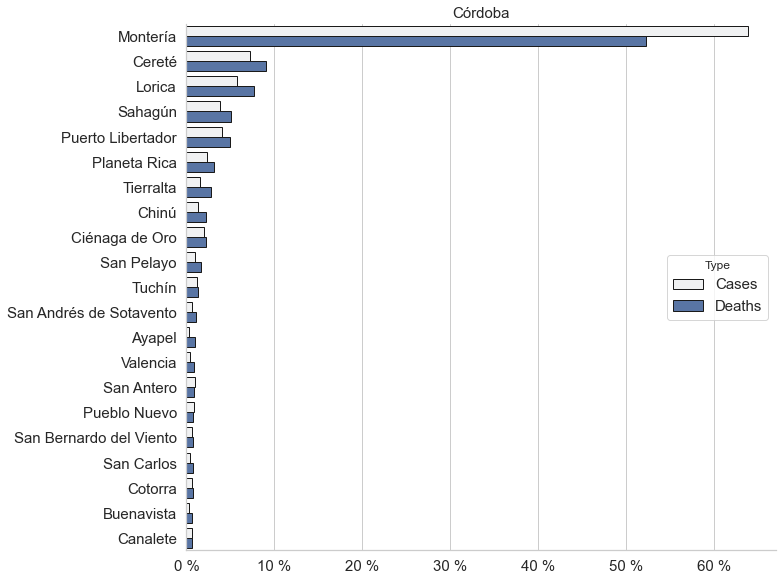

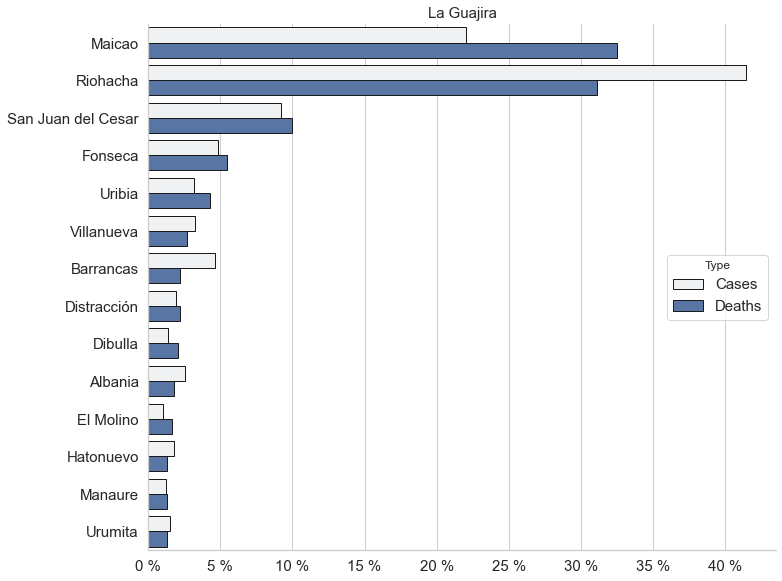

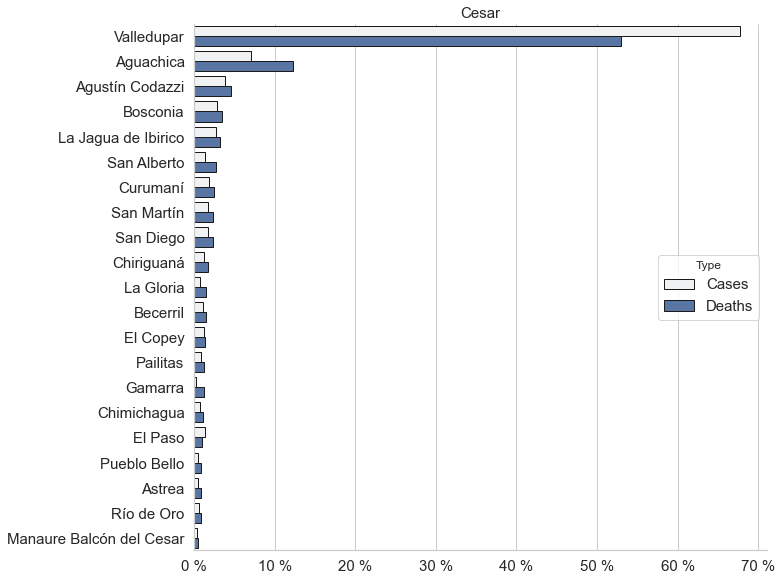

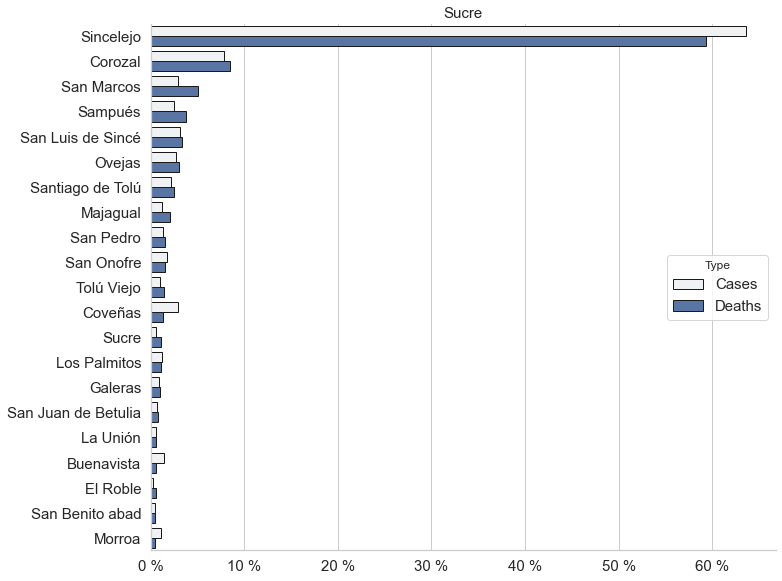

In [6]:
from unidecode import unidecode
import seaborn as sns

sns.set_color_codes("pastel")
sns.set_theme(style="whitegrid")

state_df = poly_df.copy(); 
state_df = state_df[["geometry", "num_cases", "num_diseased", "attr_population", "poly_name"]]

state_df["state_name"] = state_df.apply(lambda x: x.poly_name.split('-')[-1], axis=1)
state_df["mun_name"]   = state_df.apply(lambda x: x.poly_name.split('-')[0], axis=1)


# Costa
def plot_incident_prop(incident_df, title, path_to_save=None):
    incident_df  = incident_df.sort_values(by='num_diseased', ascending=False)
    incident_df  = incident_df.iloc[:21]
    frac         = np.concatenate((100 * incident_df["num_cases"].values / incident_df["num_cases"].sum(), 100 * incident_df["num_diseased"].values / incident_df["num_diseased"].sum())  )

    incident_df = pd.concat([incident_df, incident_df])
    incident_df['frac']  = frac
    incident_df['type']  = ['Cases']* (len(incident_df)//2) + ['Deaths']*(len(incident_df)//2)

    ax = sns.catplot(x="frac", y="mun_name", hue='type', data=incident_df,  edgecolor='k', color="b", kind='bar', height=8, aspect=5/4)
    sns.despine(top=True, right=True)
    ax.legend.set_visible(False)
    ax.axes[0][0].xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f} %"))
    ax.axes[0][0].tick_params(axis='both', labelsize=15)
    ax.axes[0][0].set_ylabel(None)
    ax.axes[0][0].set_xlabel(None)
    ax.axes[0][0].legend(loc="center right", frameon=True, title='Type', fontsize=15)
    plt.tight_layout()
    
    if title:
        plt.title(title, fontsize=15)

    if path_to_save:
        ax.fig.savefig(path_to_save,  dpi=300,  bbox_inches='tight', transparent=True)

list_state   = ['Bolívar', 'Magdalena' ,'Atlántico' , 'Córdoba' , 'La Guajira' , 'Cesar' , 'Sucre']


path_to_save = os.path.join(colev_dir, 'analisis_costa_6-april-2021')
for st in list_state:

    name_fig = '_'.join(unidecode(st.lower()).split(' '))
    ss_df = state_df[state_df.state_name==st].sort_values(by='num_diseased', ascending=False)
    plot_incident_prop(ss_df, title=st, path_to_save=os.path.join(path_to_save,  name_fig+'_distribution.png') )
    plt.show()


- Cartagena de Indias-Bolívar 13001
- Santa Marta-Magdalena 47001
- Barranquilla-Atlántico 8001
- Montería-Córdoba 23001
- Maicao-La Guajira 44430
- Valledupar-Cesar 20001
- Sincelejo-Sucre 70001

In [8]:

#poly_info[poly_id]

list_state   = ['Bolívar', 'Magdalena' ,'Atlántico' , 'Córdoba' , 'La Guajira' , 'Cesar' , 'Sucre']


path_to_save = os.path.join(colev_dir, 'analisis_costa_6-april-2021')
for st in list_state:

    name_fig = '_'.join(unidecode(st.lower()).split(' '))
    ss_df = state_df[state_df.state_name==st].sort_values(by='num_diseased', ascending=False).reset_index()
    polys_keep = ss_df.poly_id.values 
    polys_keep

In [37]:
st = 'Magdalena'

name_fig = '_'.join(unidecode(st.lower()).split(' '))
ss_df = state_df[state_df.state_name==st].sort_values(by='num_diseased', ascending=False).reset_index()
polys_keep = ss_df.poly_id.values 
polys_keep = polys_keep[:10]
    
df_cases_state_df = df_cases_all.copy().reset_index()
df_cases_state_df = df_cases_state_df[df_cases_state_df.poly_id.isin(polys_keep)]
df_cases_state_df


,date_time,poly_id,poly_name,poly_state,age_group,num_cases,smoothed_num_cases,num_diseased,smoothed_num_diseased
833946,2020-07-22,47551,Pivijay,Magdalena,10-10,2.0,1.0,0.0,0.0
833947,2020-07-23,47551,Pivijay,Magdalena,10-10,0.0,0.0,0.0,0.0
833948,2020-07-24,47551,Pivijay,Magdalena,10-10,0.0,0.0,0.0,0.0
833949,2020-07-25,47551,Pivijay,Magdalena,10-10,0.0,0.0,0.0,0.0
833950,2020-07-26,47551,Pivijay,Magdalena,10-10,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1075549,2021-03-21,47318,Guamal,Magdalena,agg,0.0,1.0,0.0,0.0
1075550,2021-03-22,47318,Guamal,Magdalena,agg,1.0,0.0,0.0,0.0
1075551,2021-03-23,47318,Guamal,Magdalena,agg,0.0,0.0,0.0,0.0
1075552,2021-03-24,47318,Guamal,Magdalena,agg,0.0,0.0,0.0,0.0


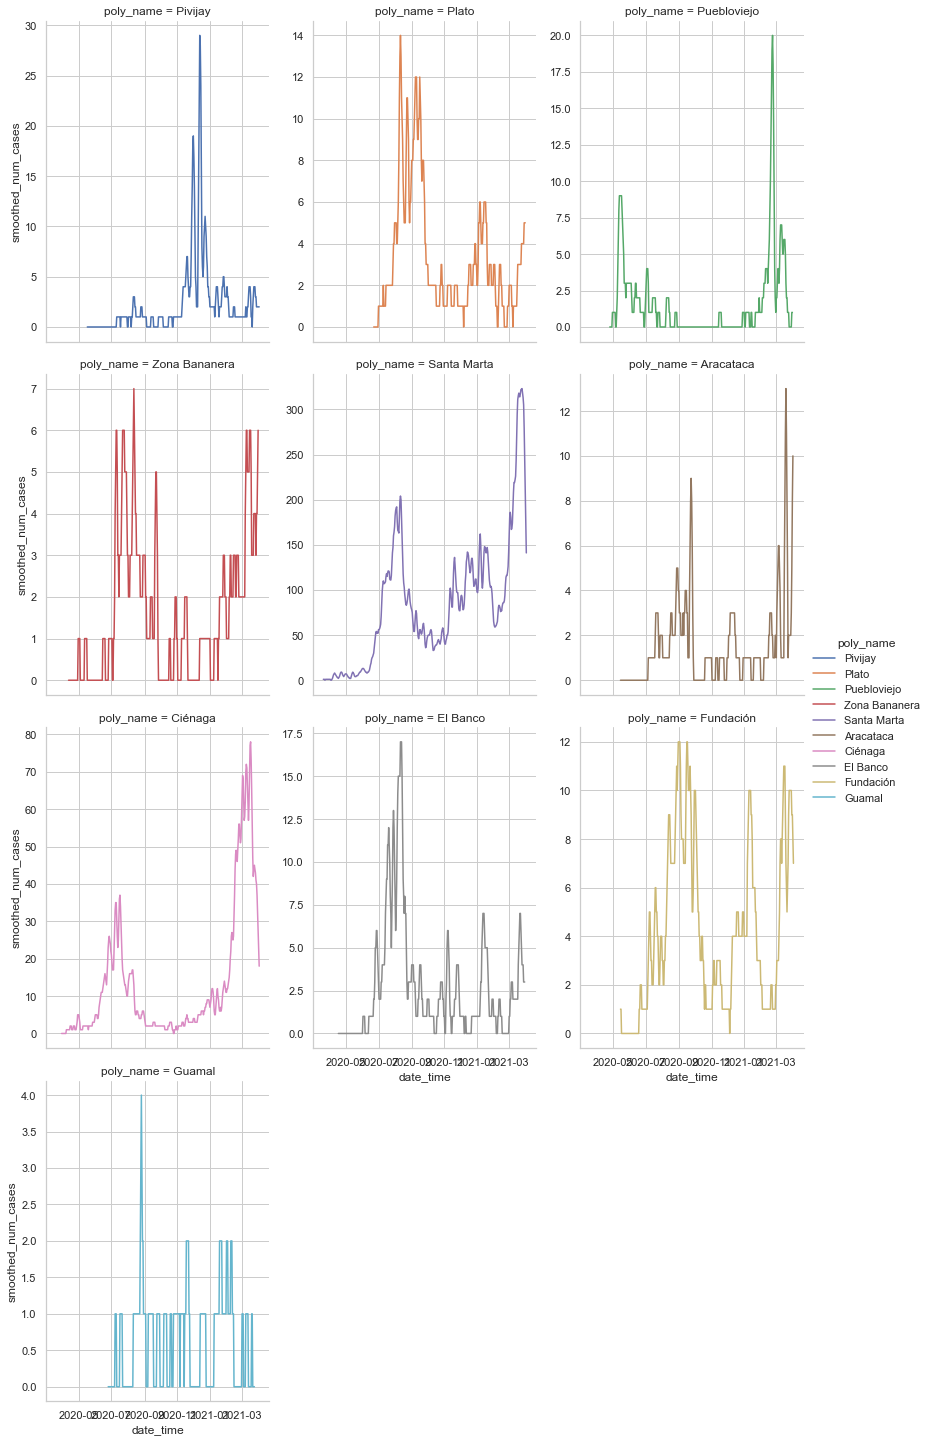

In [39]:

#palette = sns.color_palette("Set3")
g = sns.relplot(
        data=df_cases_state_df[df_cases_state_df.age_group=='agg'],
        x="date_time", y="smoothed_num_cases",
        hue="poly_name", col="poly_name",
        kind="line",
        col_wrap=3,
        height=5, 
        aspect=.75, 
        facet_kws=dict(sharex=True, sharey=False),
        )


In [ ]:
ss_df
poly_info[70001]

In [ ]:
python3 estimate.py 70001 sincelejo True
python3 create_files.py 70001 sincelejo True
python3 plot_forecast_figures.py 70001 sincelejo True
